## Exploring the Results from Cloud Vision

#### Import statements

In [26]:
import matplotlib
import matplotlib.pylab as plt
import tensorflow as tf
import pandas as pd
import json
import os
import io
import sys
import time
import random
import statistics
from PIL import Image
import PIL

In [2]:

dataset_dir = os.path.expanduser("~") + "/datasets/handwriting/IAM_Handwriting_Top50/"
images_dir = dataset_dir + "data_subset/"
analysis_dir = dataset_dir + "gcloud_analysis/"

fullTextAnnotationDict = {}

for filename in os.listdir(analysis_dir):
    f = os.path.join(analysis_dir, filename)
    
    with open(f, encoding='utf-8', errors='ignore') as file: 
        try :
            js = json.load(file)
            
            fullTextAnnotationDict[filename] = js['responses'][0]['fullTextAnnotation']
        except:
            print("Error processing: ", filename)

Error processing:  m06-031-s02-00.json
Error processing:  a01-058u-s01-00.json
Error processing:  r06-097-s03-01.json
Error processing:  .DS_Store
Error processing:  c03-087b-s00-01.json
Error processing:  m06-031-s03-00.json
Error processing:  g06-011n-s01-03.json
Error processing:  n06-123-s03-00.json
Error processing:  d06-050-s03-00.json
Error processing:  a06-134-s01-00.json
Error processing:  g06-042i-s01-00.json
Error processing:  g06-011l-s01-00.json
Error processing:  a01-058u-s03-00.json
Error processing:  d06-063-s00-02.json
Error processing:  p03-112-s05-00.json
Error processing:  g06-011n-s04-02.json
Error processing:  j06-008-s02-00.json
Error processing:  g06-042g-s01-00.json
Error processing:  c03-003f-s02-00.json
Error processing:  g06-089-s02-03.json
Error processing:  g06-018c-s01-00.json
Error processing:  m06-031-s04-00.json
Error processing:  n06-163-s02-00.json
Error processing:  c03-087a-s01-03.json
Error processing:  g06-050n-s02-00.json
Error processing:  g06-

In [3]:
len(fullTextAnnotationDict)

4866

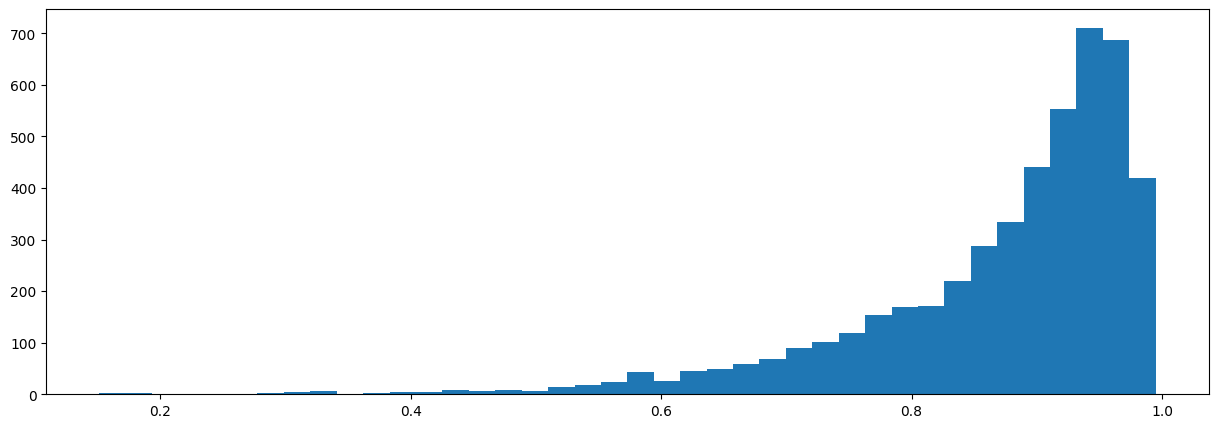

In [4]:
# For the IAM top 50, the dataset was curated for only one page per image
confidence = [x['pages'][0]['confidence'] for x in fullTextAnnotationDict.values()]
cpd = pd.DataFrame(confidence)
# print(len(confidence))
plt.figure(figsize=(15, 5))
plt.hist(cpd.values, bins=40)
plt.show()

#### Get the confidence Levels Per Author

In [5]:
img_author = {}
authors = {}
author_errors = {}
from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
# forms = pd.read_csv('../input/iam-handwriting-top50/forms_for_parsing.txt', header=None)
# print(forms.head)
with open(dataset_dir + '/forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        img_author[key] = writer
        if writer not in authors:
            authors[writer] = []
            author_errors[writer] = []
        authors[writer].append(key)
print("# Authors: ", len(authors.keys()))
print("# Images: ", len(img_author.keys())) # Images are segmented

# Authors:  657
# Images:  1539


Define helper functions to be used while processing

In [6]:
def getFilenameKey(filename: str):
    return '-'.join(filename.split("-")[0:2])

#### Show the error rates per author

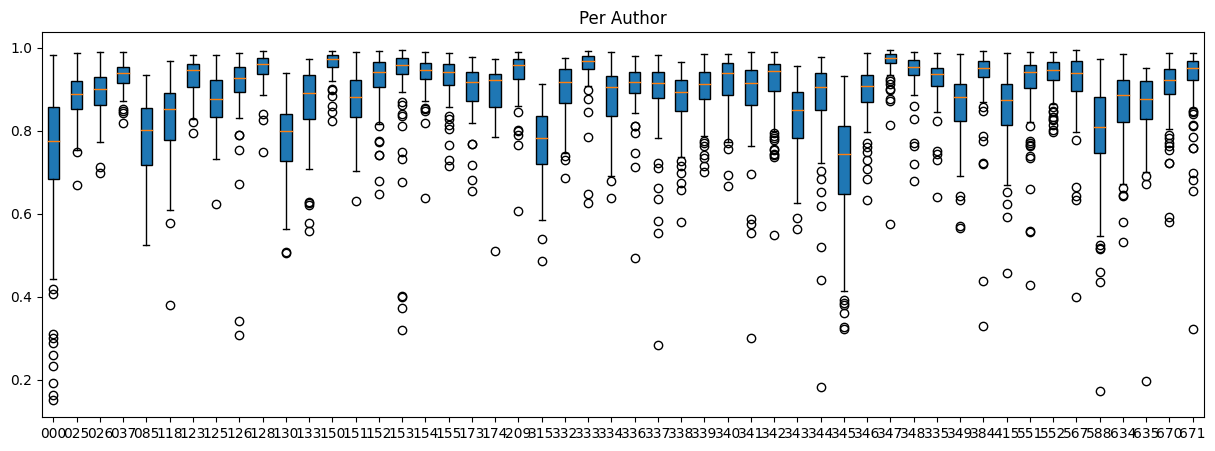

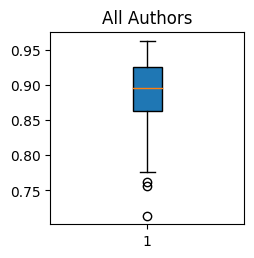

In [7]:
# Create dictionaries
for filename, json_resp in fullTextAnnotationDict.items():
    fn_key = getFilenameKey(filename)
    author = img_author[fn_key]
    confidence = json_resp['pages'][0]['confidence']
    author_errors[str(author)].append(confidence)

author_errors_filtered = { k:v for (k,v) in author_errors.items() if len(v) > 0 }

# Box Plot Per Author
plt.figure(figsize=(15, 5))
plt.title("Per Author")
plt.boxplot(author_errors_filtered.values(), vert=True, patch_artist=True)
plt.xticks(range(1, len(author_errors_filtered.keys()) + 1), author_errors_filtered.keys())
plt.show()

# Average over all authors
plt.figure(figsize=(2.5, 2.5))
plt.title("All Authors")
author_normalized_errors = {k: statistics.mean(v) for k, v in author_errors_filtered.items()}
plt.boxplot(author_normalized_errors.values(), vert=True, patch_artist=True)
plt.show()

According to the chart above the approximate mean error for all authors is ~0.90 with an upper IQR of ~0.92.

#### Filter Outliers & Inaccurate Data

In [8]:
# Filter all with < .85 confidence and is English
max_alpha = 0.15
high_confidence_analyses = {}
texts = []

def isascii(s):
    """Check if the characters in string s are in ASCII, U+0-U+7F."""
    return len(s) == len(s.encode())

for filename, json_resp in fullTextAnnotationDict.items():
    language = None
    confidence = 0.0
    text = None
    try:
        fn_key = getFilenameKey(filename)
        author = img_author[fn_key]
        confidence = json_resp['pages'][0]['confidence']
        language   = json_resp['pages'][0]['property']['detectedLanguages'][0]['languageCode']
        text       = json_resp['text']
        # print(language)
    except:
        language = None
        text = None
        # print("Error: ", json_resp)
    
    if (1 - confidence) < max_alpha and language == "en" and text and isascii(text):
        texts.append(text)
        high_confidence_analyses[filename] = json_resp

print("# High Confidence Images: ", len(high_confidence_analyses.keys()))


# High Confidence Images:  3152


##### Remaining

- Group Images by author
- TFREC files


Write Up

#### Image saving helper functions

In [31]:
def getBoundingBox(symbols):
    boundingBox = None
    try:
        if len(symbols) == 1:
            vertices = symbols[0]['boundingBox']['vertices']
            boundingBox = (
                vertices[0].get('x', 0),
                vertices[0].get('y', 0),
                vertices[1].get('x', 0),
                vertices[2].get('y', 0)
            )
        else: # TODO - this should be made dynamic and support > 2 chars
            vertices1 = symbols[0]['boundingBox']['vertices']
            vertices2 = symbols[1]['boundingBox']['vertices']
            boundingBox = (
                vertices1[0].get('x', 0),
                vertices1[0].get('y', 0) if vertices1[0].get('y', sys.maxsize) < vertices2[0].get('y', sys.maxsize) else vertices1[0].get('y', 0),
                vertices2[1].get('x', 0),
                vertices1[2].get('y', 0) if vertices1[2].get('y', 0) > vertices2[0].get('y', 0) else vertices2[0].get('y', 0)
            )
        # Cloud Vision will return < 0 if it thinks the char starts "off" the image
        if boundingBox[0] > boundingBox[2] or boundingBox[1] > boundingBox[3]:
            raise Exception("BB ERROR")
        return tuple(0 if x < 0 else x for x in boundingBox)
    except: 
        print("BOUNDING BOX ERROR:\n", symbols)
        return None


def string_to_hex(s):
    return s.encode('utf-8').hex()

def hex_to_string(h):
    return bytes.fromhex(h).decode('utf-8')

def getLetters(symbols):
    if len(symbols) == 1:
        return symbols[0]['text']
    else:
        return symbols[0]['text'] + symbols[1]['text']

def cropImage(pil_image, bounding_box):
    return pil_image.crop(bounding_box)
    
def resizeImage(pil_image, x_px, y_px):
    return pil_image.resize((x_px, y_px), PIL.Image.LANCZOS)

def saveImage(pil_image, chars_str, image_path, filename):
    rand_v = str(random.randint(1, 1000000000))
    chars_hash = string_to_hex(chars_str)
    img_path = image_path + chars_hash + "/"
    
    if not os.path.exists(img_path):
       os.makedirs(img_path)
    
    full_path = img_path + filename.replace('.json', '') + "-" + rand_v + '.png'
    # print(full_path)
    pil_image.save(full_path)

In [32]:
# Todo: Parallelize

start_time = time.time()
updated_image_size_x = 56
updated_image_size_y = 56
crop_dir       = dataset_dir + 'cropped/'
author_dir     = crop_dir + 'author/'
std_img_dir    = crop_dir + 'std/'
resize_img_dir = crop_dir + 'resized/'

for filename, json_resp in high_confidence_analyses.items():
    fn_key = getFilenameKey(filename)
    author = img_author[fn_key]
    x = 0
    blocks = []
    # max_letter_set_length = 2 # TODO allow for more than 2 letters in a row
    unmanipulated_image = Image.open(images_dir + filename.replace('json', 'png'))
    # convert image to grayscale and remove non-white values from the background
    gray_threshold = 192
    grayscale_img = unmanipulated_image.convert("L").point(lambda p: 255 if p > gray_threshold else 0)
    for block in json_resp['pages'][0]['blocks']:
        if block['blockType'] != "TEXT":
            print("Non-text block type detected: ", block['type'])
            continue
        for paragraph in block["paragraphs"]:
            for word in paragraph["words"]:
                previous_symbols = []
                for symbol in word["symbols"]:
                    try:
                        previous_symbols.append(symbol)

                        # Single character:
                        single_symbol = [symbol]
                        bb = getBoundingBox(single_symbol)
                        if (bb == None):
                            continue
                        chars = getLetters(single_symbol)

                        std_image = cropImage(grayscale_img, bb)
                        saveImage(std_image, chars, std_img_dir, filename)

                        rsz_image = resizeImage(std_image, updated_image_size_x, updated_image_size_y)
                        saveImage(rsz_image, chars, resize_img_dir, filename)
                        # Resize By author
                        saveImage(rsz_image, chars, author_dir + author + "/", filename)


                        # Two chars
                        psl = len(previous_symbols)
                        previous_symbol = previous_symbols[psl-2] if psl > 1 else None
                        if previous_symbol != None:
                            symbols = [previous_symbol, symbol]
                            bb = getBoundingBox(symbols)
                            if (bb == None):
                                continue
                            chars = getLetters(symbols)

                            # Standard image
                            std_image = cropImage(grayscale_img, bb)
                            saveImage(std_image, chars, std_img_dir, filename)


                            # Thumbnailed/downsampled image
                            rsz_image = resizeImage(std_image, updated_image_size_x, updated_image_size_y)
                            saveImage(rsz_image, chars, resize_img_dir, filename)

                            # Resize By author
                            saveImage(rsz_image, chars, author_dir + author + "/", filename)
                    except Exception as e:
                        print("Error During Image Saving: ", e)
                        
end_time = time.time()
run_time = end_time - start_time
print(f"Run time: {run_time} seconds")

BOUNDING BOX ERROR:
 [{'boundingBox': {'vertices': [{'x': 1576, 'y': 31}, {'x': 1574, 'y': 63}, {'x': 1524, 'y': 60}, {'x': 1526, 'y': 28}]}, 'confidence': 0.93727064, 'property': {'detectedBreak': {'type': 'LINE_BREAK'}}, 'text': '6'}]
BOUNDING BOX ERROR:
 [{'boundingBox': {'vertices': [{'x': 1198, 'y': 97}, {'x': 1162, 'y': 98}, {'x': 1161, 'y': 59}, {'x': 1197, 'y': 58}]}, 'confidence': 0.9315463, 'property': {'detectedBreak': {'type': 'LINE_BREAK'}}, 'text': 'b'}]
Error During Image Saving:  tile cannot extend outside image
BOUNDING BOX ERROR:
 [{'boundingBox': {'vertices': [{'x': 369, 'y': 83}, {'x': 330, 'y': 83}, {'x': 330, 'y': 38}, {'x': 369, 'y': 38}]}, 'confidence': 0.5998575, 'text': 'O'}]
BOUNDING BOX ERROR:
 [{'boundingBox': {'vertices': [{'x': 334, 'y': 82}, {'x': 292, 'y': 82}, {'x': 292, 'y': 37}, {'x': 334, 'y': 37}]}, 'confidence': 0.42659467, 'property': {'detectedBreak': {'type': 'LINE_BREAK'}}, 'text': 'N'}]
BOUNDING BOX ERROR:
 [{'boundingBox': {'vertices': [{'x'

Create TFRec files from Author Folder

In [38]:
def bytesFeature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()]))

def serializeExample(image):
    feature = {
        'image': bytesFeature(image),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


In [39]:
start_time = time.time()

for author_id in os.listdir(author_dir):
    author_path = os.path.join(author_dir, author_id)
    if os.path.isdir(author_path):
        tfrecord_filename = os.path.join(author_path, f"{author_id}.tfrec")
        with tf.io.TFRecordWriter(tfrecord_filename) as writer:
            for dirpath, _, filenames in os.walk(author_path):
                for filename in filenames:
                    if filename.endswith('.png'):
                        image_path = os.path.join(dirpath, filename)
                        image = tf.io.decode_image(tf.io.read_file(image_path))

                        tf_example = serializeExample(image)
                        writer.write(tf_example)  

end_time = time.time()
run_time = end_time - start_time
print(f"Run time: {run_time} seconds")